## Problem Statement
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

**The data set contains the following diseases:**

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Importing necessary Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, MaxPool2D, Activation, Flatten, Dropout, Dense,Conv2D
)

from tensorflow.keras.layers import Rescaling

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
#from tensorflow.keras.layers.experimental.preprocessing import Rescaling
#from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

#from tensorflow.keras.utils import to_categorical
#from tensorflow.keras.utils.np_utils import to_categorical



In [2]:
# path to your dataset
DATASET_PATH = './Skin cancer ISIC The International Skin Imaging Collaboration'

**This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.**

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
train_path = f"{DATASET_PATH}/Train"
test_path = f"{DATASET_PATH}/Test"
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Train Image Count:- {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Test Image Count:- {image_count_test}")

Train Image Count:- 2239
Test Image Count:- 118


#### Visualizing Images

Found 2239 files belonging to 9 classes.


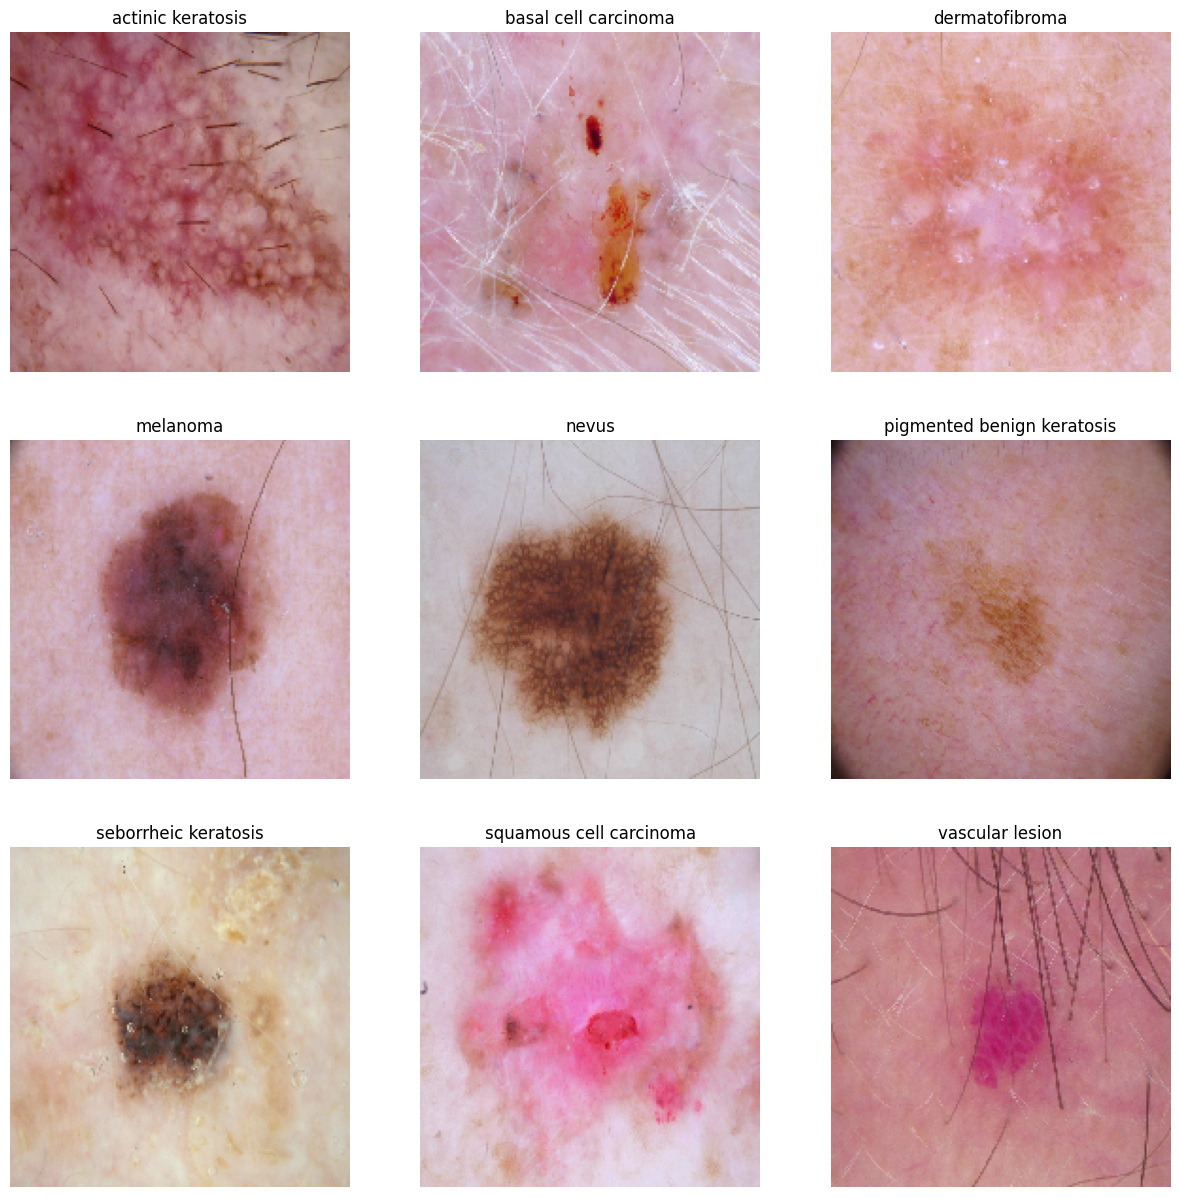

In [5]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), 
# representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

Accoring to question we have 9 different types of categories

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**The Keras preprocessing layers API allows developers to build Keras-native input processing pipelines. These input processing pipelines can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.**

Here we are working with Image preprocessing and we have below preprocessors

- layer_resizing(): resizes a batch of images to a target size.
- layer_rescaling(): rescales and offsets the values of a batch of images (e.g., going from inputs in  the [0, 255] range to inputs in the [0, 1] range.
- layer_center_crop(): returns a center crop of a batch of im

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# validation dataset 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

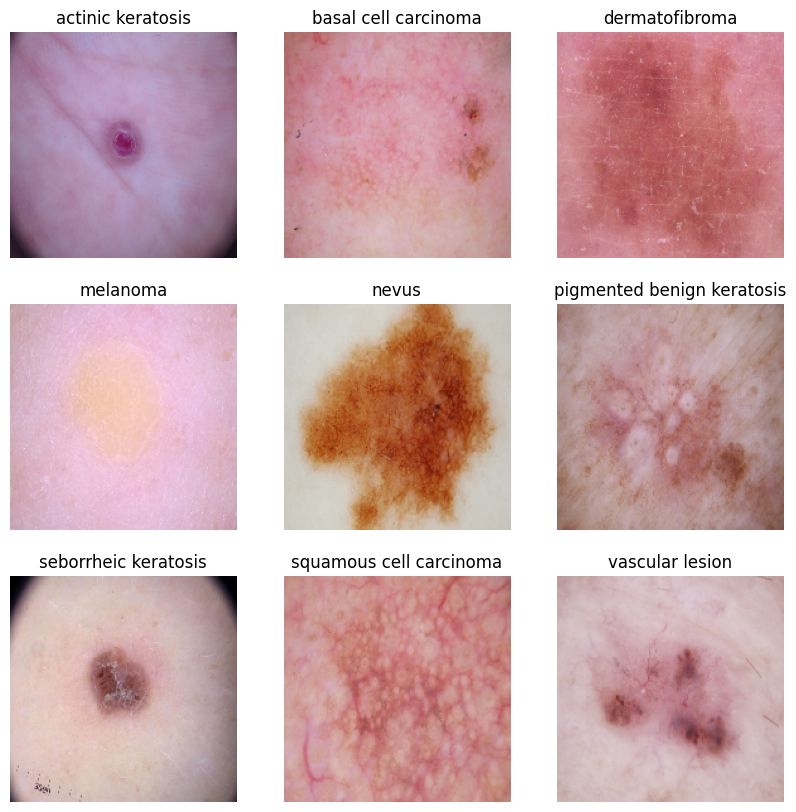

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Model Creation

**This model is before handling imbalance in train dataset**

In [13]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer
#Adding Normalization
model.add(BatchNormalization())
# Here i am adding 3 convoluation layers

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding="Same",kernel_initializer='glorot_uniform'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding="Same",kernel_initializer='glorot_uniform'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding="Same",kernel_initializer='glorot_uniform'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

c:\Users\Subhrajit.Pyne\OneDrive - Wolters Kluwer\Desktop\AI and ML Course Doc\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,405 (30.61 MB)

 Trainable params: 8,024,399 (30.61 MB)

 Non-trainable params: 6 (24.00 B)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.
model.compile(optimizer="Adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

### Train the model

In [15]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 267ms/step - accuracy: 0.2514 - loss: 2.8251 - val_accuracy: 0.1857 - val_loss: 2.0752
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.4572 - loss: 1.6045 - val_accuracy: 0.2013 - val_loss: 2.0455
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.4625 - loss: 1.4843 - val_accuracy: 0.2528 - val_loss: 1.9288
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.5463 - loss: 1.3301 - val_accuracy: 0.4004 - val_loss: 1.6873
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - accuracy: 0.6077 - loss: 1.1341 - val_accuracy: 0.4787 - val_loss: 1.5248
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 282ms/step - accuracy: 0.6470 - loss: 1.0133 - val_accuracy: 0.4989 - val_loss: 1.4138
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.6789 - loss: 0.8928 - val_accuracy: 0.5414 - val_loss: 1.2601
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 273ms/step - accuracy: 0.7181 - loss: 0.7864 - val_accu

### Visualizing training results

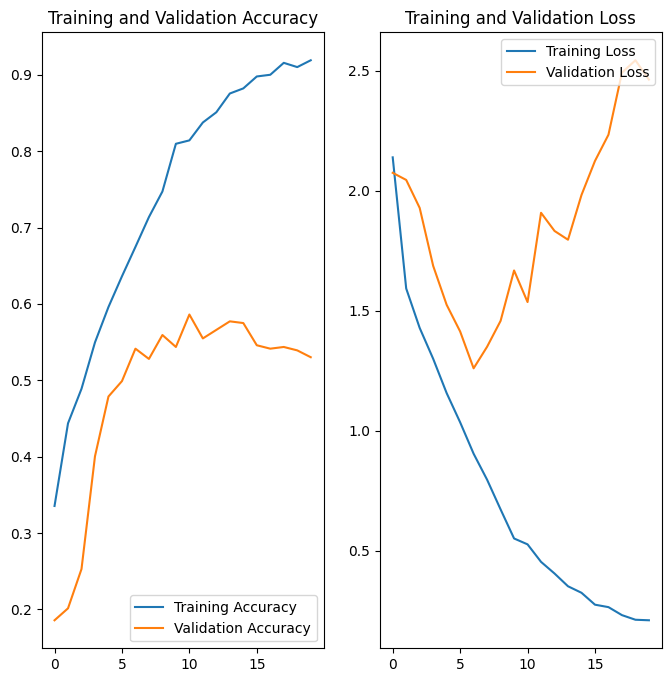

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Check fort Over or Underfit

In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.9496 - loss: 0.1169
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5387 - loss: 2.4429
Accuracy:  0.9397321343421936
Validation Accuracy:  0.5302013158798218
Loss:  0.13125933706760406
Validation Loss 2.4638209342956543


**From the above we can clearly say, it is overfitting (Train Acc: 0.93 and test acc: 0.53). We need to balance our dataset here and also
need to use Normalization**

**Here we are using Augmentor to augment images**

In [18]:
#Using Augmentor to augment image
#path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    print (f"Current Iteration {train_path + i}")
    p = Augmentor.Pipeline(train_path+"/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainactinic keratosis
Initialised with 114 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1784E32B2C0>: 100%|██████████| 500/500 [00:01<00:00, 358.67 Samples/s]                  


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainbasal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17843DA6B70>: 100%|██████████| 500/500 [00:01<00:00, 398.47 Samples/s]                  


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Traindermatofibroma
Initialised with 95 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17844EE0560>: 100%|██████████| 500/500 [00:01<00:00, 389.70 Samples/s]                  


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainmelanoma
Initialised with 438 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17843BE6930>: 100%|██████████| 500/500 [00:05<00:00, 96.86 Samples/s]                    


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainnevus
Initialised with 357 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x17840AA52E0>: 100%|██████████| 500/500 [00:04<00:00, 107.22 Samples/s]                    


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainpigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1784E40CFB0>: 100%|██████████| 500/500 [00:01<00:00, 372.10 Samples/s]                  


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainseborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17843BE4E90>: 100%|██████████| 500/500 [00:02<00:00, 209.29 Samples/s]                  


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainsquamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1784E48C530>: 100%|██████████| 500/500 [00:01<00:00, 350.32 Samples/s]                  


Current Iteration ./Skin cancer ISIC The International Skin Imaging Collaboration/Trainvascular lesion
Initialised with 139 image(s) found.
Output directory set to ./Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1784500C5F0>: 100%|██████████| 500/500 [00:01<00:00, 341.23 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [19]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Visualizing Data

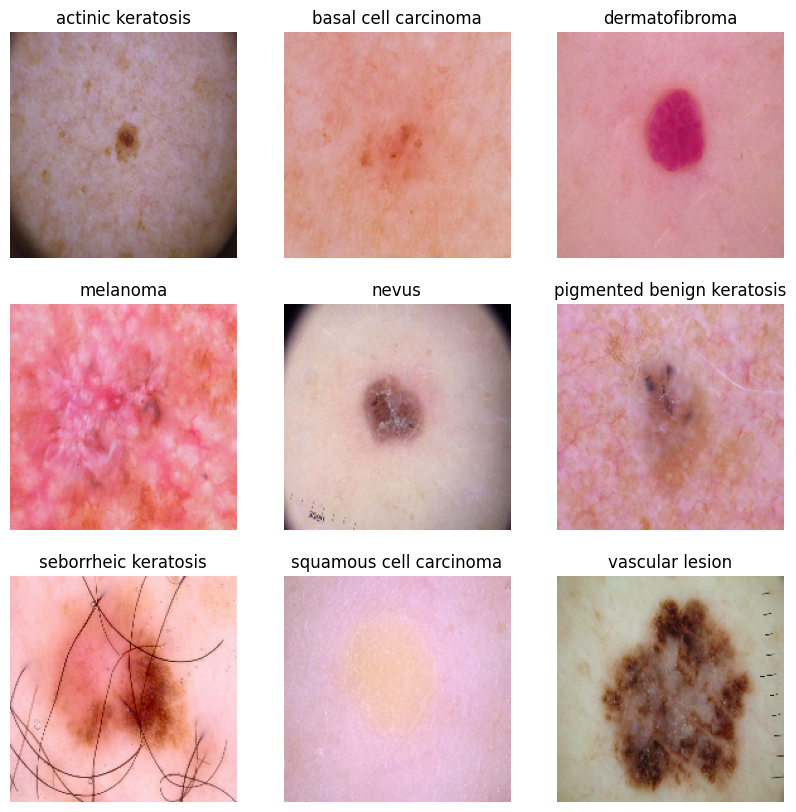

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

### Lets see the distribution of augmented data after adding new images to the original training data.

In [21]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_41cb0353-eb7c-4f22-9213-cf458d2aff7f.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_9bf30f10-498c-4277-9f29-d3c536610413.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_abe70c20-7225-4af5-b575-7c6eb7c6eeac.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_397c041c-8d15-46ea-b5f1-c1193de25b93.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_c20168d0-7624-4931-b1c7-8ae32566eaee.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [22]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [23]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [24]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(columns = ['Path','Label'])

new_df = pd.concat ([original_df,df2])


In [25]:
new_df['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### : Train the model on the data created using Augmentor

In [26]:
batch_size = 32
img_height = 180
img_width = 180

In [27]:

# data_dir_train = pathlib.Path(path_list_new)


# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split=0.2,
#   subset="training",  # Use "training" to refer to the training data
#   image_size=(img_height, img_width),
#   batch_size=batch_size
# )

data_dir_train= train_path

# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir_train,
#   seed=123,
#   validation_split = 0.2,
#   subset = 'training',
#   image_size=(img_height, img_width),
#   batch_size=batch_size)


# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               batch_size=batch_size,
                                                               image_size=(img_height, img_width), 
                                                               label_mode='categorical',
                                                               seed=123,
                                                               subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [28]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                            batch_size=batch_size,
                                                            image_size=(img_height, img_width), 
                                                            label_mode='categorical',
                                                            seed=123,
                                                            subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [29]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model (make sure to include normalization)

In [30]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

#Adding Normalization
model.add(BatchNormalization())

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# Here i am adding 3 convoluation layers

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding="Same",kernel_initializer='glorot_uniform'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding="Same",kernel_initializer='glorot_uniform'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding="Same",kernel_initializer='glorot_uniform'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales logits into probabilities.
#As we have 9 classes, we are using 9 neurons at dense layer

model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

c:\Users\Subhrajit.Pyne\OneDrive - Wolters Kluwer\Desktop\AI and ML Course Doc\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Compile model

In [31]:

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights
#(in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.Also, if there will be any error, we will
#have most recent working one to use.
checkpoint = ModelCheckpoint("model.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",
                          patience=5,
                          mode="auto",
                          verbose=1)

#### Train model

In [32]:
# Train the model
epochs = 30

#The learning rate is reduced by a factor after a specific numbers of epochs. 
# For example, you might start with a learning rate of 0.1 and reduce it by a factor 
# of 0.5 every 10 epochs. This method is simple yet effective, allowing for 
# initial rapid learning that slows down over time.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs,
                    callbacks=[checkpoint,earlystop,learning_rate_reduction])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.1695 - loss: 2.1370
Epoch 1: val_accuracy improved from -inf to 0.20193, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 50s 276ms/step - accuracy: 0.1697 - loss: 2.1367 - val_accuracy: 0.2019 - val_loss: 2.0637 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.2778 - loss: 1.9358
Epoch 2: val_accuracy improved from 0.20193 to 0.35189, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 261ms/step - accuracy: 0.2779 - loss: 1.9354 - val_accuracy: 0.3519 - val_loss: 1.6939 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.3584 - loss: 1.6650
Epoch 3: val_accuracy improved from 0.35189 to 0.37342, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 259ms/step - accuracy: 0.3584 - loss: 1.6650 - val_accuracy: 0.3734 - val_loss: 1.5839 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step -

#### Plotting the Curves

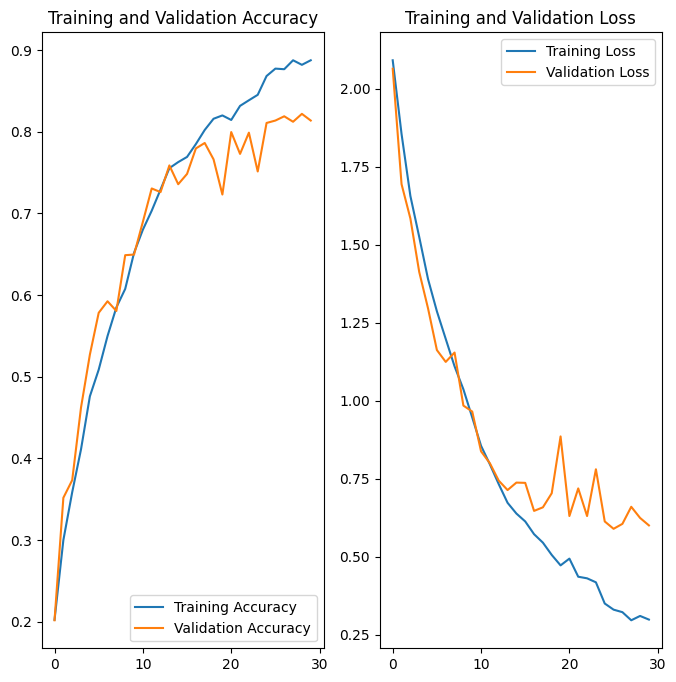

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Check For Overfit and Underfit

In [34]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9514 - loss: 0.1543
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8283 - loss: 0.5651
Accuracy:  0.949184000492096
Validation Accuracy:  0.8136599659919739
Loss:  0.1589047908782959
Validation Loss 0.600456714630127


**After adding normalization and augmetation, the performance has imporoived significantly. Though it is still overfitting but the difference is much leser than previous.**

#### Model Prediction on Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Actual Class pigmented benign keratosis
Predictive Class pigmented benign keratosis


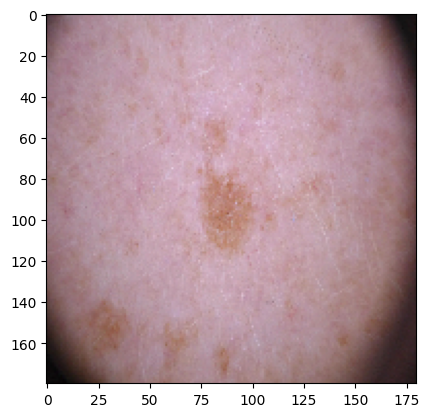

In [35]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[5], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-5],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[5] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Actual Class nevus
Predictive Class nevus


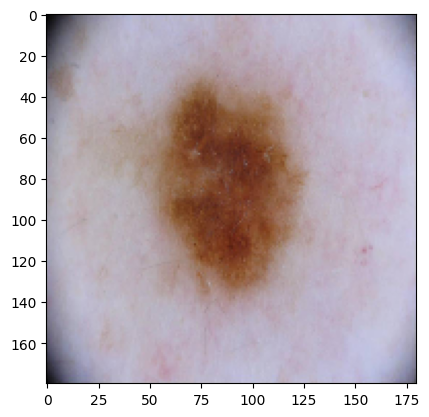

In [36]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-4],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Actual Class dermatofibroma
Predictive Class dermatofibroma


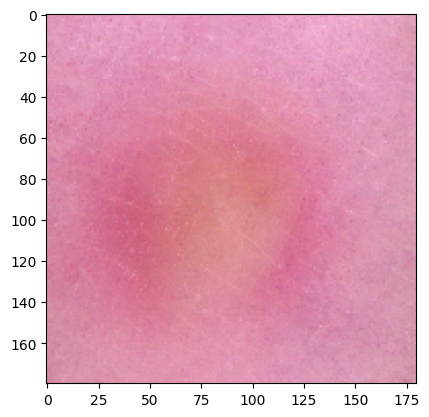

In [38]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-2],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[2] +'\n'+ "Predictive Class "+pred_class )

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

**Ans:- After applying augmentation on train pictures, the result has improved significantly. Before applying it, the difference between train and validation accuracy was more than 0.41 which is reduced to 0.12 after applying augmentation. Though overfitting is still there but we are getting correct result on Test.**